### Mask-RCNN Starter Model for the RSNA Pneumonia Detection Challenge with transfer learning 

#### Problem statement and objective:

The objective is to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, the algorithm needs to automatically locate lung opacities on chest radiographs. We are given to understand from the problem statement that diagonising pneumonia requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. As per the problem statement, Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.

CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift. 

Keeping these challenges in mind, we are exploring the possibility of usine computer vision techniques to reduce the time taken and the human efforts in detect pneumonia from chest radiographs. Especially with the COVID19 pandemic unveiling currently across the world, the timely detection and reducing the time taken to diagonise by using computer vision techniques is more of a need of the hour in saving lives and containing the pandemic.

#### Breif introduction on Mask RCNN model:
Mask RCNN is a deep neural network aimed to solve instance segmentation problem in machine learning or computer vision. In other words, it can separate different objects in a image or a video. 

***It gives the below output on an input image:***
1. Object bounding boxes
2. Classes
3. Masks

***Model architecture:***

There are two stages of Mask RCNN. First, it generates proposals about the regions where there might be an object based on the input image. Second, it predicts the class of the object, refines the bounding box and generates a mask in pixel level of the object based on the first stage proposal. Both stages are connected to the backbone structure. The model imported from  is based on Feature Pyramid Network (FPN) and a ResNet101 backbone. Refer the project report for more details on the model.

***Transfer learning applied:***
Pre-trained COCO weights trained on http://cocodataset.org 
Mask RCNN Model importerd from https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon

#### Rational behind exploring a Mask RCNN model:

We chose Mask RCNN as it also predicts a mask highlighting the pixels of the target object in the image in addition to the bounding box and the class of the object which we consider a significant value add to the detection algorithm. We believe the Mask highlights would be an appropriate depiction of infected cells in the patient in addition to the bounding box. By using transfer learning technique and the pre-trained weights from a model trained on the COCO-dataset we have predicted the mask highlighting the pixels displaying lung opacity and also the bounding box highlighting the lung opacity in the patients radiology profile.


Note: Considering the limitations on the computing resources available we have limited the training to 25 epochs with 50 steps per epoch.

#### Accuracy achieved
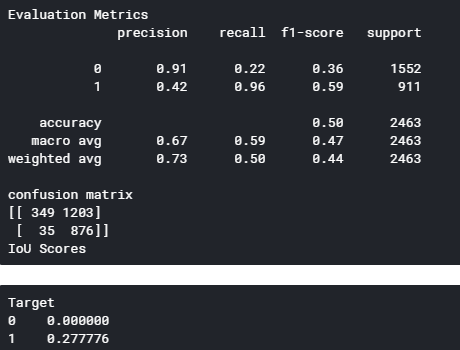

#### Conclusion
On increasing the number of epochs from the previous trial run from 16 to 25 and including image augmentation technique the accuracy scores improved from 43% to 50%. Due to computing resource constrains we are concluding on the algorithm without training it further. However, if we continue training the algorithm for higher number of epochs we would be able to achieve better accuracy of the model and make it fit to be used for medical diagnostic purposes.

### Importing some essential liabraries and packages

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold
import matplotlib.patches as patches

In [2]:
# Assigning link to the input data
DATA_DIR = '/kaggle/input'

# Directory to save logs and trained model
ROOT_DIR = '/kaggle/working'

In [3]:
#### changing the directory to the input data directory to view the contents and changing it back to the working directory

In [4]:
cd /kaggle/input

/kaggle/input


In [5]:
ls

GCP Credits Request Link - RSNA.txt  stage_2_test_images/
stage_2_detailed_class_info.csv      stage_2_train_images/
stage_2_sample_submission.csv        stage_2_train_labels.csv


In [6]:
cd /kaggle/working

/kaggle/working


In [7]:
# Assigning the link to training dataset and test dataset directories
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

### Visualising the data provided

In [8]:
# visualising the training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [9]:
# visualising the test dataset
sample_sub = pd.read_csv(os.path.join(DATA_DIR,'stage_2_sample_submission.csv'))
sample_sub.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


In [10]:
# visualising the file detailed_class_info
class_info = pd.read_csv(os.path.join(DATA_DIR,'stage_2_detailed_class_info.csv'))
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [11]:
# Number of patient's scan images
anns.shape

(30227, 6)

In [12]:
# Number of unique patients
anns['patientId'].nunique()

26684

In [13]:
# Number of classes
anns['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [14]:
anns['patientId'].duplicated()

0        False
1        False
2        False
3        False
4        False
5         True
6        False
7        False
8        False
9         True
10       False
11       False
12       False
13       False
14       False
15        True
16       False
17        True
18       False
19       False
20        True
21       False
22       False
23       False
24       False
25        True
26       False
27       False
28        True
29       False
         ...  
30197    False
30198    False
30199     True
30200    False
30201     True
30202    False
30203     True
30204    False
30205    False
30206    False
30207    False
30208    False
30209     True
30210    False
30211    False
30212    False
30213    False
30214    False
30215     True
30216    False
30217    False
30218    False
30219    False
30220     True
30221    False
30222     True
30223    False
30224    False
30225    False
30226     True
Name: patientId, Length: 30227, dtype: bool

There are 30227 scanned images and 26684 patients. This implies that there are a few patients with multiple clusters of lung opacity issue.

In [15]:
#Visualising the metadata of the dicom file

sample_patientId = anns.iloc[30226]['patientId']
sample_img = train_dicom_dir+'/'+sample_patientId+'.dcm'
meta_data = pydicom.read_file(sample_img) # read dicom image from filepath 
meta_data

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.9955.1517874345.895762
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'c1f7889a-9ea9-4acb-b64c-b737c929599a'
(0010, 0020) Patient ID                          LO: 'c1f7889a-9ea9-4acb-b64c-b737c929599a'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

Metadata mostly contains technical aspects of the image captured. However, Patient's sex and Age could be used to futher fine tune the performance of the model as they would add more color in terms of the gender and the age group that is more likely to be affected by class 2 pneumonia.

And it is also noted the images are of the size 1024*1024.

In [16]:
# Visualising a sample image
def visualise(i):
  imageArea, axes = plt.subplots(1)
  sample_patientId = anns.iloc[i]['patientId']
  sample_img = train_dicom_dir+'/'+sample_patientId+'.dcm'
  
  meta_data = pydicom.read_file(sample_img) # read dicom image from filepath 
  sample_img_array = meta_data.pixel_array # get image array
  
  for _,row in anns[anns.patientId == sample_patientId].iterrows():
    x, y, width, height  = row.x, row.y, row.width, row.height

  
  
  # Create a Rectangle patch
    rect = patches.Rectangle((x, y), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')
    axes.imshow(sample_img_array, cmap=plt.cm.bone)

  # Add the patch to the Axes
    axes.add_patch(rect)

  plt.show()
  print('patientId: ' + sample_patientId)
  print('Target: '+ str(anns.iloc[i]['Target']))
  print('Age: '+ meta_data.PatientAge)
  print('Sex: '+ meta_data.PatientSex)
  print('Img_size: '+ str(meta_data.Rows))

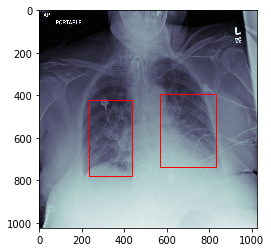

patientId: c1f7889a-9ea9-4acb-b64c-b737c929599a
Target: 1
Age: 72
Sex: F
Img_size: 1024


In [17]:
visualise(30226)

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [18]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 39.81 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [19]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


### Download COCO pre-trained weights

In [20]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [21]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [22]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 50

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [23]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [24]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [25]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [26]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [27]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

25184 1500


### Create and prepare the training dataset using the DetectorDataset class.

In [28]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [29]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
/kaggle/input/stage_2_train_images/8cf9fffd-08ef-448b-b9ec-1074d9e5691e.dcm
[1 1]


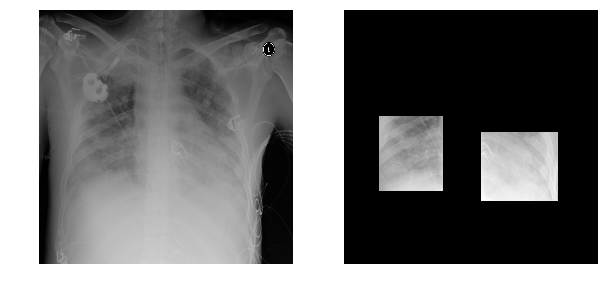

In [30]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

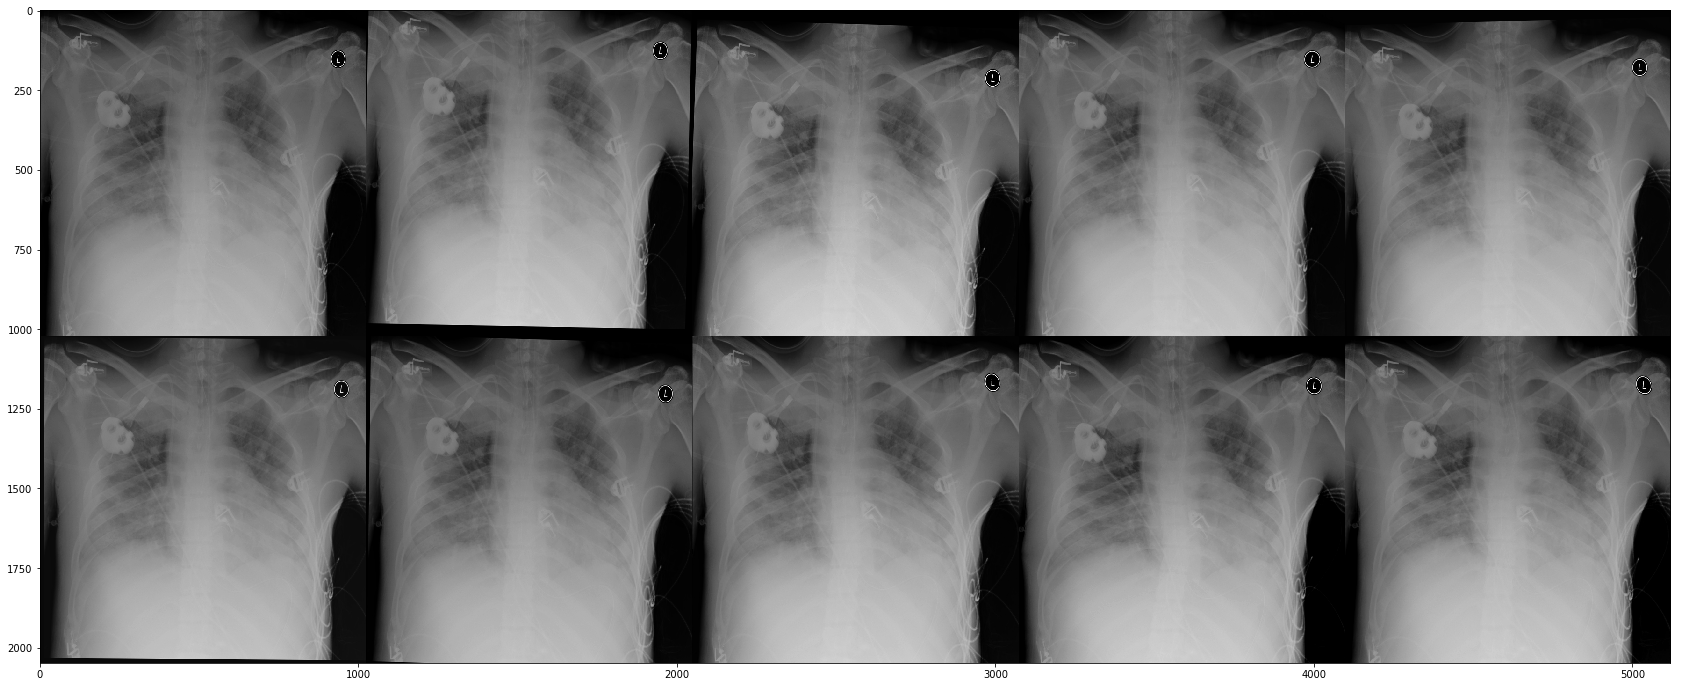

In [31]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

#### Training the model

Note: Given the size of the data set even training a basic model can take a few hours. We have limited the training to 25 epochs, and have set nominal values for the Detector Configuration to reduce run-time.

- dataset_train and dataset_val are derived from DetectorDataset
- DetectorDataset loads images from image filenames and masks from the annotation data
- model is Mask-RCNN

In [32]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [33]:
LEARNING_RATE = 0.006

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [34]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=5,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /kaggle/working/pneumonia20200531T1256/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4 

In [35]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=15,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 5. LR=0.006

Checkpoint Path: /kaggle/working/pneumonia20200531T1256/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

50/50 [==============================] - 359s 7s/step - loss: 1.5438 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.1964 - mrcnn_bbox_loss: 0.4413 - mrcnn_mask_loss: 0.4050 - val_loss: 1.5520 - val_rpn_class_loss: 0.0178 - val_rpn_bbox_loss: 0.4575 - val_mrcnn_class_loss: 0.2263 - val_mrcnn_bbox_loss: 0.4638 - val_mrcnn_mask_loss: 0.3866
CPU times: user 11min 42s, sys: 26.9 s, total: 12min 9s
Wall time: 1h 9min 4s


In [36]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=25,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 15. LR=0.0012000000000000001

Checkpoint Path: /kaggle/working/pneumonia20200531T1256/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D

50/50 [==============================] - 320s 6s/step - loss: 1.2871 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3796 - mrcnn_class_loss: 0.1507 - mrcnn_bbox_loss: 0.3658 - mrcnn_mask_loss: 0.3793 - val_loss: 1.4031 - val_rpn_class_loss: 0.0134 - val_rpn_bbox_loss: 0.4881 - val_mrcnn_class_loss: 0.1479 - val_mrcnn_bbox_loss: 0.3779 - val_mrcnn_mask_loss: 0.3758
CPU times: user 11min 17s, sys: 27.4 s, total: 11min 45s
Wall time: 1h 11min 39s


In [37]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.953986,0.022720,0.570214,0.341446,0.623745,0.395859,2.051129,0.029443,0.576282,0.309200,0.689216,0.446987
2,1.737049,0.018114,0.564821,0.217647,0.539606,0.396860,1.720865,0.023418,0.531585,0.248082,0.524458,0.393320
3,1.861256,0.032533,0.643729,0.273513,0.521693,0.389787,1.897890,0.023503,0.714681,0.254804,0.506384,0.398516
4,2.110310,0.022633,0.856527,0.308885,0.522985,0.399279,1.802801,0.025783,0.614907,0.283280,0.497144,0.381685
5,3.000032,0.047581,1.904473,0.131742,0.531396,0.384836,1.850620,0.025292,0.675799,0.250209,0.509902,0.389416
6,1.742983,0.023395,0.669746,0.231533,0.429968,0.388332,1.892477,0.024365,0.697020,0.278178,0.490350,0.402554
7,1.609267,0.019281,0.493577,0.223787,0.474816,0.397798,1.728570,0.019851,0.586246,0.259413,0.452462,0.410589
8,1.715150,0.023311,0.570104,0.264634,0.479801,0.377291,1.660357,0.021110,0.548716,0.234133,0.452204,0.404184
9,1.667546,0.021381,0.547962,0.252153,0.459443,0.386596,1.638078,0.019676,0.522366,0.244278,0.450918,0.400830
10,2.305179,0.028152,1.253667,0.178941,0.454894,0.389516,1.673103,0.019390,0.518792,0.262226,0.458328,0.414357


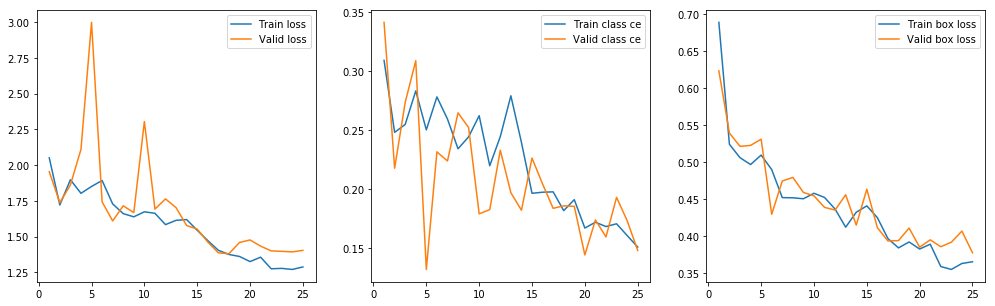

In [38]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [39]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 18 1.379222948551178


In [40]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumonia20200531T1256/mask_rcnn_pneumonia_0018.h5


In [41]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/pneumonia20200531T1256/mask_rcnn_pneumonia_0018.h5
Re-starting from epoch 18


In [42]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 



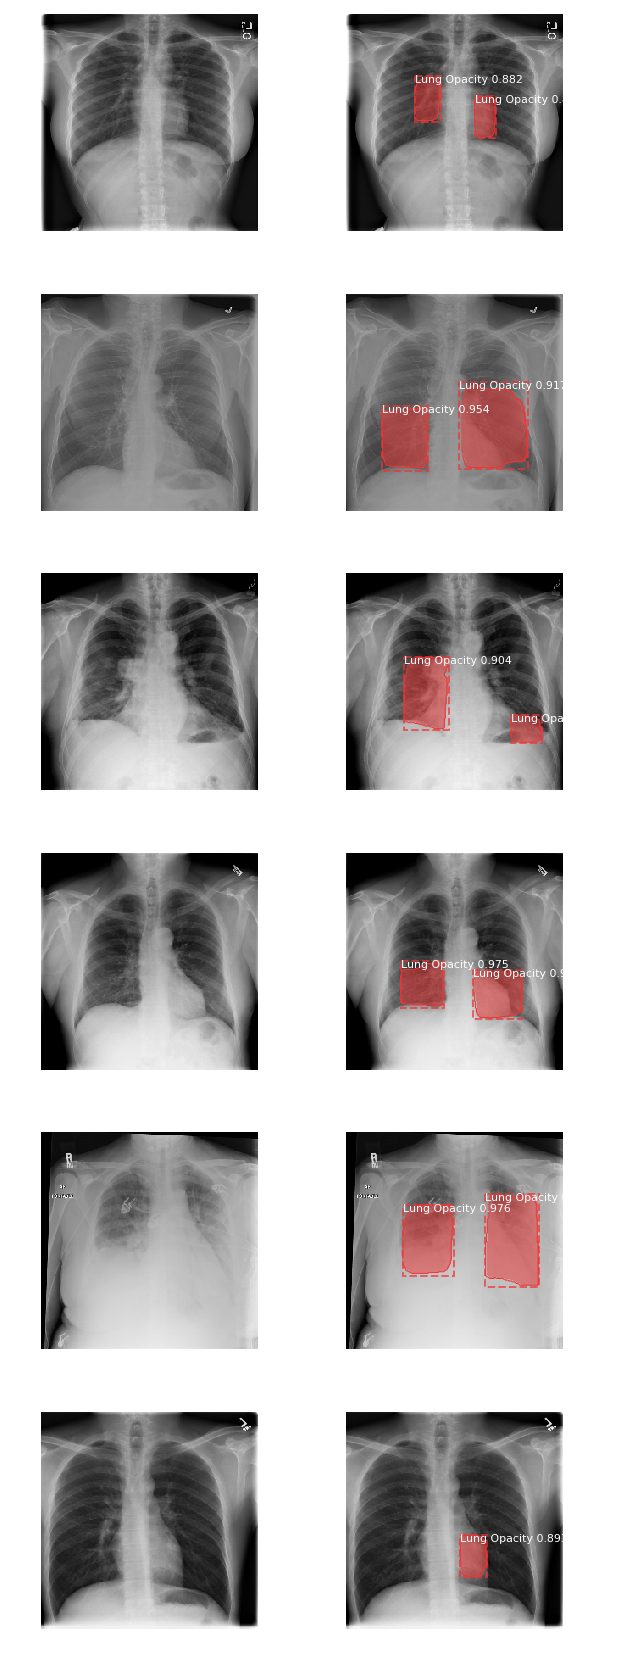

In [43]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

## Evaluating the performance of the model
We are evaluating the models based on the below metrics
1. Accuracy
2. Precision
3. Recall
4. F1 score
5. Mean IoU

In [44]:
# Make predictions on test images, write out sample submission
def predict_val(image_fps, filepath='val_sample.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,score,x1,y1,width,height\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) != 0:
              num_instances = len(r['rois'])
              score = []  
              for i in range(num_instances):
                    score.append(r['scores'][i])
                    
                    if r['scores'][i] >= min_conf:
                      out_str = ""
                      out_str += patient_id
                      out_str += ","
                      out_str += ""
                      out_str += str(round(r['scores'][i], 2))
                      out_str += ","
                      x1 = r['rois'][i][1]
                      out_str += ""
                      out_str += str(x1*resize_factor)
                      out_str += ","
                      y1 = r['rois'][i][0]
                      out_str += ""
                      out_str += str(y1*resize_factor)
                      out_str += ","
                      width = r['rois'][i][3] - x1
                      out_str += ""
                      out_str += str(width*resize_factor)
                      out_str += ","
                      height = r['rois'][i][2] - y1
                      out_str += ""
                      out_str += str(height*resize_factor)
                      out_str += ","
                      file.write(out_str+"\n")
                    
              if max(score) < min_conf:
                      out_str = ""
                      out_str += patient_id
                      out_str += ","
                      file.write(out_str+"\n")  
            
            else:
                out_str = ""
                out_str += patient_id
                out_str += ","
                file.write(out_str+"\n")

In [45]:
val_sample_fp = os.path.join(ROOT_DIR, 'val_sample.csv')
predict_val(image_fps_val, filepath=val_sample_fp)
print(val_sample_fp)

100%|██████████| 1500/1500 [07:00<00:00,  3.51it/s]

/kaggle/working/val_sample.csv


In [46]:
col_names = ["patientId","score_pred","x_pred","y_pred","width_pred","height_pred"]
val_pred = pd.read_csv(val_sample_fp, delimiter = ",", names = col_names)
val_pred.drop(val_pred.index[0], inplace = True)
val_pred.sort_values(by = "patientId", inplace = True)
val_pred

,patientId,score_pred,x_pred,y_pred,width_pred,height_pred
1752,00293de0-a530-41dc-9621-0b3def01d06d,0.98,136.0,556.0,280.0,260.0
1753,00293de0-a530-41dc-9621-0b3def01d06d,0.95,628.0,576.0,280.0,300.0
198,008c19e8-a820-403a-930a-bc74a4053664,0.98,572.0,460.0,200.0,260.0
1383,00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b,0.98,196.0,524.0,236.0,360.0
1384,00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b,0.96,600.0,472.0,248.0,432.0
948,01469010-0fab-4a07-86c6-962996ce2ca0,0.95,300.0,472.0,152.0,168.0
1066,02002619-3dea-4038-8d4d-458db30ed8de,0.98,164.0,204.0,276.0,556.0
1028,021082a9-a734-42a8-bbe2-233e19a59103,NaN,NaN,NaN,NaN,NaN
620,02242633-faa0-4927-81de-b2b44940068a,0.98,584.0,468.0,268.0,296.0
619,02242633-faa0-4927-81de-b2b44940068a,0.98,172.0,500.0,228.0,232.0


In [47]:
validation_list = set(val_pred['patientId'])
val_actuals = anns[anns['patientId'].isin(validation_list)]
val_actuals.sort_values(by = "patientId", inplace = True)
len(validation_list)

1500

In [48]:
val_compare = pd.merge(val_pred, val_actuals, how='inner', on= 'patientId', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [49]:
val_compare.fillna(0, inplace = True)

In [50]:
val_compare.dtypes

patientId       object
score_pred      object
x_pred          object
y_pred          object
width_pred      object
height_pred     object
x              float64
y              float64
width          float64
height         float64
Target           int64
dtype: object

In [51]:
val_compare['score_pred'] = val_compare['score_pred'].astype(float)
val_compare['x_pred'] = val_compare['x_pred'].astype(float)
val_compare['y_pred'] = val_compare['y_pred'].astype(float)
val_compare['height_pred'] = val_compare['height_pred'].astype(float)
val_compare['width_pred'] = val_compare['width_pred'].astype(float)

In [52]:
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 

In [53]:
results = confusion_matrix(val_compare['Target'], val_compare['score_pred'].round())  

In [54]:
# Defining function to find IoU scores
def IOU(x,y,width,height,x_pred,y_pred,width_pred,height_pred):
    w_intersection = min(x + width, x_pred + width_pred) - max(x, x_pred)
    h_intersection = min(y + height, y_pred + height_pred) - max(y, y_pred)
    if w_intersection <= 0 or h_intersection <= 0: # No overlap
        return 0
    I = w_intersection * h_intersection
    U = width * height + width_pred * height_pred - I # Union = Total Area - I
    return I / U

In [55]:
# Creating a column for IoU values
val_compare['IoU'] = val_compare.apply(lambda x: IOU(x['x'],x['y'],x['width'],x['height'],x['x_pred'],x['y_pred'],x['width_pred'],x['height_pred']),axis=1)

In [56]:
print("Evaluation Metrics")
print(classification_report(val_compare['Target'], val_compare['score_pred'].round()))
print("confusion matrix")
print(results)
print("IoU Scores")
val_compare.groupby('Target')["IoU"].mean()
# accuracy: (tp + tn) / (p + n)
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# f1: 2 tp / (2 tp + fp + fn)
# Mean IoU: Mean value of intersection/ Union of the area and position of the bounding box ground truth and predictions

Evaluation Metrics
              precision    recall  f1-score   support

           0       0.91      0.22      0.36      1552
           1       0.42      0.96      0.59       911

    accuracy                           0.50      2463
   macro avg       0.67      0.59      0.47      2463
weighted avg       0.73      0.50      0.44      2463

confusion matrix
[[ 349 1203]
 [  35  876]]
IoU Scores


Target
0    0.000000
1    0.277776
Name: IoU, dtype: float64

### Final steps - Create the submission file

In [57]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [58]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [59]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [09:13<00:00,  7.25it/s] 

/kaggle/working/submission.csv


In [60]:
output = pd.read_csv(submission_fp)
output.head(60)

,patientId,PredictionString
0,1d3af918-bbac-4859-a6e0-4497599334dc,NaN
1,14b51a44-118d-42ac-91f8-f072f3eacc7b,0.97 272.0 516.0 236.0 260.0
2,28a903f0-ca6b-4e7f-9587-7812b25e794f,0.98 616.0 384.0 240.0 276.0 0.98 252.0 344.0...
3,2cd87e35-29b6-42cf-99c7-0b6815cce40b,0.98 272.0 372.0 240.0 424.0
4,031b6254-ded2-423a-947a-c4018797c544,0.96 268.0 420.0 168.0 160.0
5,299e8dc9-1ddf-4bb9-bbf9-6545506e10a7,0.96 548.0 452.0 244.0 228.0
6,0fc6f60b-6a29-432a-94a5-a466eaaa91ab,0.98 256.0 464.0 228.0 204.0 0.97 628.0 460.0...
7,035a2dce-5d55-401c-9038-3fc93f291a97,0.95 208.0 404.0 240.0 268.0
8,c0471814-5d65-4868-94cb-e9ff37439619,NaN
9,02697c06-6d28-49ec-a66e-2eeafeb19358,0.98 216.0 476.0 208.0 192.0 0.96 580.0 516.0...


1bb7ca9c-c1ea-4054-93ee-44009e6cc119
[ 50  44 125 117]
x 176 y 200 h 292 w 300
[ 61 137 103 169]
x 548 y 244 h 128 w 168
[116 146 145 189]
x 584 y 464 h 172 w 116
28f0e911-7f0e-43de-8b6a-70fb1b77f21c
2ebf08b7-83db-453f-bba8-9abc4caaacd1
[ 57 141 188 212]
x 564 y 228 h 284 w 524
[147  27 200  92]
x 108 y 588 h 260 w 212
[ 64  48 137 113]
x 192 y 256 h 260 w 292
1ec28d4c-00d2-4370-bcd4-58067ba215d6
[106 158 168 225]
x 632 y 424 h 268 w 248
[ 90  99 144 127]
x 396 y 360 h 112 w 216


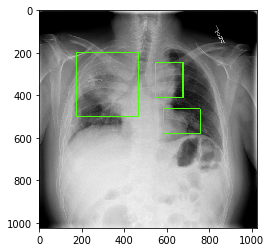

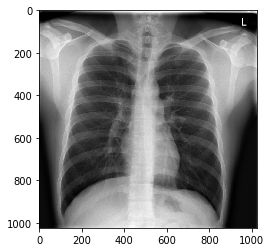

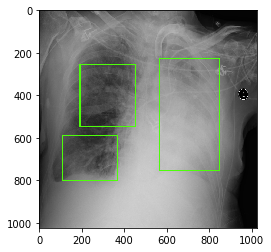

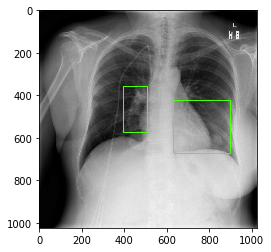

In [61]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()

### Saving the model files, weights and other metric data

In [63]:
# Saving the final model and its weights as a HDF5 files
import keras
keras.models.save_model(model.keras_model,"mask_rcnn_RSNA.hdf5")
keras.models.save_weights(model.keras_model,"mask_rcnn_RSNA_weights.hdf5")

OSError: Unable to create file (unable to truncate a file which is already open)

In [64]:
# Saving the validation data metrics and the training history to CSV files
val_compare.to_csv('validation_metrics.csv')
history.to_csv('mrcnn_training_lossvals.csv')

OSError: [Errno 28] No space left on device

In [ ]:
# remove files to allow committing (hit files limit otherwise)
#!rm -rf /kaggle/working/Mask_RCNN